# ANN Forecast Trainer

In [2]:
#Create progress bar function
def progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = '\r')
    if iteration == total: 
        print()

In [3]:
# Importing the libraries
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LayerNormalization, Add, Reshape
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import save_model
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping

days=1

# Importing the dataset
market_prices = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['price[EUR/MWh]'].values
dates = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['date'].values
# read the numpy file
wind_speed_forecasting = np.load('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2022_wind_forecast.npy')[:,:]
wind_speed = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['wind_speed'].values

In [4]:
# Create a DataFrame
data = []
for i in range(len(market_prices)-days*24):
    data.append([market_prices[i], dates[i], wind_speed[i]]) # append the price, date and wind speed (windspeed is shifted by days)

data = pd.DataFrame(data, columns=['price', 'date', 'wind_speed'])
# Convert 'date' to datetime, ensuring timezone info is retained if present
data['date'] = pd.to_datetime(data['date'], utc=True)

# If the data isn't timezone-aware, assume it's UTC and then convert. Otherwise, directly convert.
data['date'] = data['date'].dt.tz_convert('Europe/Copenhagen')  # Converting to Copenhagen timezone

data['day_of_week'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour
data = pd.get_dummies(data, columns=['day_of_week'], prefix='weekday')

# Ensure all weekdays are represented
for i in range(7):
    if f'weekday_{i}' not in data.columns:
        data[f'weekday_{i}'] = 0

# Define peak hours and possibly other features
data['peak_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 20 else 0)
# Add lagged price features
for lag in range(1, 25):
    data[f'price_lag_{lag}'] = data['price'].shift(lag)
    data[f'price_future_{lag}'] = data['price'].shift(-lag)
    data[f'wind_speed_future_lag_{lag}'] = data['wind_speed'].shift(-lag)

feature_columns = ['price', 'hour', 'peak_hours', 'wind_speed'] + [f'weekday_{i}' for i in range(7)] + [f'price_lag_{i}' for i in range(1, 25)] + [f'wind_speed_future_lag_{i}' for i in range(1, 25)]
target_columns = [f'price_future_{i}' for i in range(1, 25)]

data_pre = data.copy()
data_pre = data_pre[data_pre['date']<=pd.Timestamp('2021-12-{} 00:00:00+0100'.format(31-days), tz='Europe/Copenhagen')]
data_post = data.copy()
data_post = data_post[data_post['date']>=pd.Timestamp('2021-12-{} 00:00:00+0100'.format(31-days), tz='Europe/Copenhagen')]

# Columns to scale
columns_to_scale = ['price', 'wind_speed'] + [f'price_lag_{i}' for i in range(1, 25)] + [f'price_future_{i}' for i in range(1, 25)] + [f'wind_speed_future_lag_{i}' for i in range(1, 25)]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))

data_post_raw = data_post.copy()
data_pre[columns_to_scale] = scaler.fit_transform(data_pre[columns_to_scale])
data_post[columns_to_scale] = scaler.transform(data_post[columns_to_scale])

#data_pre = data_pre[feature_columns + target_columns]
data_pre = data_pre.dropna()#.astype(np.float32)
#data_post = data_post[feature_columns + target_columns]
data_post = data_post.dropna()#.astype(np.float32)

In [5]:
X_pre, y_pre = data_pre[feature_columns].astype(np.float32).values, data_pre[target_columns].astype(np.float32).values
X_post, y_post = data_post[feature_columns].values, data_post[target_columns].values


X_pre_pre = X_pre[:-100]
y_pre_pre = y_pre[:-100]
X_pre_post = X_pre[-100:]
y_pre_post = y_pre[-100:]

# Split data into training and test sets
X_train = X_pre_pre
y_train = y_pre_pre
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
X_val = X_pre_post.reshape((X_pre_post.shape[0], X_pre_post.shape[1], 1))
y_val = y_pre_post.reshape((y_pre_post.shape[0], y_pre_post.shape[1], 1))

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, Add, Reshape

# Define the LSTM part of the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# First LSTM block with dropout
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = Dropout(0.1)(x)

# Second LSTM block with residual connection, also using Bidirectional
x_residual = Bidirectional(LSTM(128, return_sequences=True))(x)
x_residual = Dropout(0.1)(x_residual)
x = Add()([x, x_residual])

# Third LSTM block with dropout
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.1)(x)

# Fourth LSTM block with dropout
x = Bidirectional(LSTM(128, return_sequences=False))(x)  # Set return_sequences to False for the last LSTM layer
x = Dropout(0.1)(x)

# Dense layers for feature generation
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer with the correct number of units
lstm_output = Dense(24)(x)  # Output shape should match the target shape (26134, 24)
output_layer = Reshape((24, 1))(lstm_output)  # Reshape to (26134, 24, 1)

# Create LSTM model
lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary to verify the output shape
#lstm_model.summary()

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(26134, 59, 1)
(26134, 24, 1)
(100, 59, 1)
(100, 24, 1)


In [9]:
# Train the LSTM model to get feature representations
lstm_model.fit(x=X_train, y=y_train, epochs=10, batch_size=32, verbose=1)#, validation_data=(X_val, y_val))

Epoch 1/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 1257s 2s/step - loss: 0.0035
Epoch 2/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 654s 801ms/step - loss: 0.0019
Epoch 3/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 333s 407ms/step - loss: 0.0017
Epoch 4/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 325s 398ms/step - loss: 0.0016
Epoch 5/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 331s 405ms/step - loss: 0.0016
Epoch 6/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 323s 395ms/step - loss: 0.0013
Epoch 7/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 338s 413ms/step - loss: 0.0014
Epoch 8/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 333s 408ms/step - loss: 0.0014
Epoch 9/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 329s 403ms/step - loss: 0.0013
Epoch 10/10
817/817 ━━━━━━━━━━━━━━━━━━━━ 664s 814ms/step - loss: 0.0012


In [10]:
# Use the LSTM model to generate features
X_train_features = lstm_model.predict(X_train)

817/817 ━━━━━━━━━━━━━━━━━━━━ 121s 148ms/step


In [11]:
lstm_model.save_weights('/Users/jonathan/Desktop/Opportunistic_OM_WIND/electricity_prices/models/lstm_model_22_reshape_train_30_epochs.weights.h5')

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
print('X_train shape:', X_train.shape)
X_train_features = X_train_features.reshape((X_train_features.shape[0], X_train_features.shape[1]))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_train = np.append(X_train, X_train_features, axis=1)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_train_features shape:', X_train_features.shape)

X_train shape: (26134, 59)
X_train shape: (26134, 83)
y_train shape: (26134, 24)
X_train_features shape: (26134, 24)


In [239]:
# Train XGBoost on the features generated by the LSTM
from sklearn.model_selection import GridSearchCV
X_train = np.append(X_train, X_train_features, axis=1)
# Define the parameter grid

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


Python(11634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12524) Malloc

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}
Best score: 0.00309416288898016


In [13]:
best_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}

In [15]:
X_train = np.append(X_train, X_train_features, axis=1)

In [16]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
xgb_model.save_model('/Users/jonathan/Desktop/Opportunistic_OM_WIND/electricity_prices/models/xgb_model_22_reshape_train.json')

In [12]:
#X_train = X_train.reshape(, X_train.shape[1], 1))
# Define the LSTM part of the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# First LSTM block with batch normalization
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second LSTM block with residual connection, also using Bidirectional
x_residual = Bidirectional(LSTM(128, return_sequences=True))(x)
x_residual = Dropout(0.3)(x_residual)
x = Add()([x, x_residual])

# Third LSTM block
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Fourth LSTM block without return_sequences
x = Bidirectional(LSTM(128))(x)
x = Dropout(0.3)(x)

# Dense layers for feature generation
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

lstm_output = Dense(days * 24)(x)
# Create LSTM model
lstm_model = Model(inputs=input_layer, outputs=lstm_output)

# Load models
lstm_model.load_weights('/Users/jonathan/Desktop/Opportunistic_OM_WIND/electricity_prices/models/lstm_model_22_reshape_train.weights.h5')

# Load model saved as .json
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('/Users/jonathan/Desktop/Opportunistic_OM_WIND/electricity_prices/models/xgb_model_22_reshape_train.json')

In [19]:
# Predict for each entry in the test dataset, starting each day
all_forecasts = np.array([])

for i in range(0, 365):
    progress_bar(i+1, 365, prefix='Progress:', suffix='Complete', length=50)
    x_predictor = data_post[data_post['date'] == pd.Timestamp('2022-01-01 00:00:00+0100') + pd.Timedelta(days=i)].iloc[0]
    for j in range(1,25):
        x_predictor[f'wind_speed_future_lag_{j}'] = wind_speed_forecasting[i,j-1]
    x_predictor[columns_to_scale] = scaler.transform(np.reshape(x_predictor[columns_to_scale], (1, -1)))[0]
    x_predictor = np.array(x_predictor[feature_columns].astype(np.float32)).reshape(1, -1, 1)
    lstm_prediction = lstm_model.predict(x_predictor, verbose=0)  # Predict the next 24 hours
    #x_predictor = np.append(x_predictor, lstm_prediction).reshape(1, -1)
    #prediction = xgb_model.predict(x_predictor)  # Predict the next 24 hours
    all_forecasts = np.append(all_forecasts, lstm_prediction.flatten())
all_forecasts = all_forecasts.reshape(-1,days*24)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [20]:
# Create an empty array with the same number of features as 'scaled_features'
forecast_length = days*24  # This should be 24 if each forecast is for 24 hours

# Create a dummy array to fill other features; using zeros or the mean of each feature during scaling
dummy_features = np.zeros((np.shape(all_forecasts)[0] * forecast_length, len(columns_to_scale)))
dummy_features[:, 0] = all_forecasts.flatten()  # Assuming the first column in scaled_features was price

# Inverse transform the forecasts
inverse_forecasts = scaler.inverse_transform(dummy_features)[:, 0]  # Extract only the price column after inverse transforming

# Reshape the inverse transformed forecasts back into the original all_forecasts shape for easier handling
forecasts_real = inverse_forecasts.reshape(len(all_forecasts),forecast_length)

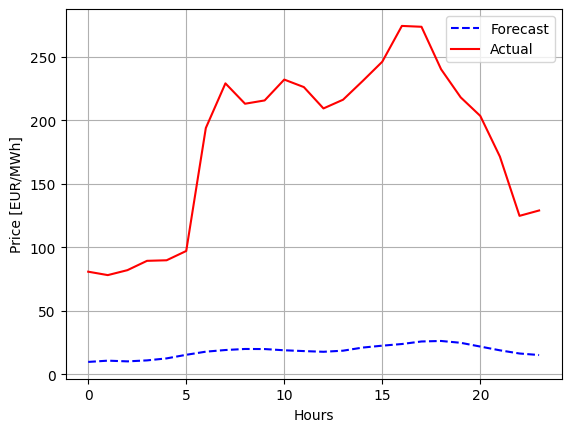

In [22]:
t = 5
plt.plot(np.arange(0,24,1), forecasts_real[t,:24], label='Forecast', color='blue', linestyle='--')
actual = []
for i in range(1,25):
    actual.append(data_post_raw[data_post_raw['date'] == pd.Timestamp('2022-01-01 00:00:00+0100') + pd.Timedelta(days=t)].iloc[0][f'price_future_{i}'])
plt.plot(np.arange(0,24,1), actual, label='Actual', color='red', linestyle='-')
plt.xlabel('Hours')
plt.ylabel('Price [EUR/MWh]')
plt.legend()
plt.grid()